# B747 Pitch Tracking using LQI Controller

This notebook formulates and solves an optimal control problem for pitch angle tracking in a Boeing 747 aircraft using a Linear Quadratic Integral (LQI) controller. The LQI extends the LQR by adding integral action to eliminate steady-state tracking errors.

The model is derived from the state-space representation of the B747 longitudinal dynamics as provided in the research paper. We minimize the quadratic cost function:

$$
J = \int_0^\infty \left( \mathbf{x}^T Q \mathbf{x} + u^T R u \right) dt
$$

augmented with an integral state for reference tracking.

We use NumPy and SciPy to solve the Algebraic Riccati Equation (ARE) and simulate the closed-loop system.

Reference Paper : Chrif, L., Kadda, Z. M., & Mohammed, L. (2020). LQR Controller and Optimal Estimation-Observer Design Applied for Pitch Aircraft B747 LQR Controller and Optimal Estimation-Observer Design Applied for Pitch Aircraft B747. *Int. J. Syst. Signal Control Eng. Appl,* 13(3), 53-58. Available at https://makhillpublications.co/files/published-files/mak-ijsscea/2020/3-53-58.pdf

## Imports

In [1]:
import numpy as np
from scipy.linalg import solve_continuous_are
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## System Model

The state-space model for the pitch dynamics (short-period approximation) is:

States $$\mathbf{x} = [w, q, \theta]^T$$ (vertical speed, pitch rate, pitch angle)
Input $$u = \delta_e$$ (elevator deflection)
Output $$y = \theta$$

From the paper:
$$ A = \begin{bmatrix} -0.3149 & 235.8928 & 0 \ -0.0034 & -0.4282 & 0 \ 0 & 1 & 0 \end{bmatrix}, \quad B = \begin{bmatrix} 5.5079 \ -0.0021 \ 0 \end{bmatrix}, \quad C = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix} $$

In [2]:
A = np.array([
    [-0.3149, 235.8928, 0],
    [-0.0034, -0.4282, 0],
    [0, 1, 0]
])
B = np.array([[5.5079], [-0.0021], [0]])
C = np.array([0, 0, 1]).reshape(1, -1)
n = A.shape[0]

# LQI Controller Design

To enable reference tracking without steady-state error, augment the system with an integral state $$e_i = \int (r - y) dt$$

## Augmented system:

$$ \dot{\mathbf{x}}{aug} = A_{aug} \mathbf{x}_{aug} + B_{aug} u, \quad A_{aug} = \begin{bmatrix} A & \mathbf{0} \ -C & 0 \end{bmatrix}, \quad B_{aug} = \begin{bmatrix} B \ 0 \end{bmatrix} $$

Choose cost matrices $Q_{aug}$ (penalizing states and integral error) and $(R)$ (penalizing control effort). Solve the *ARE* for $P$:

$$ A_{aug}^T P + P A_{aug} - P B_{aug} R^{-1} B_{aug}^T P + Q_{aug} = 0 $$

Then, the optimal gain is $$K_{aug} = R^{-1} B_{aug}^T P$$ split into $K_x$ and $K_i$.

In [3]:
# Augment for integral action
A_aug = np.block([
    [A, np.zeros((n, 1))],
    [-C, np.array([[0]])]
])
B_aug = np.block([[B], [np.array([[0]])]])

# Cost matrices (tune Qi for integral penalty)
Qi = 10.0  # Integral weight
Q_aug = np.diag([1e-3, 1e-3, 1.0, Qi])  # Small penalties on w and q, higher on theta and integral
R = np.array([[1.0]])

# Solve ARE
P = solve_continuous_are(A_aug, B_aug, Q_aug, R)

# Optimal gain
K_aug = np.linalg.inv(R) @ B_aug.T @ P
K_x = K_aug[:, :n]  # Gain for states
K_i = K_aug[:, n]   # Gain for integral
print("K_x:", K_x)
print("K_i:", K_i)

K_x: [[  0.06743897  -9.50227645 -20.19158218]]
K_i: [3.16227766]


## Closed-Loop Simulation

Simulate the augmented system with feedback (u = -K_x \mathbf{x} - K_i e_i).

Reference: step to 0.2 rad (about 11.5°).

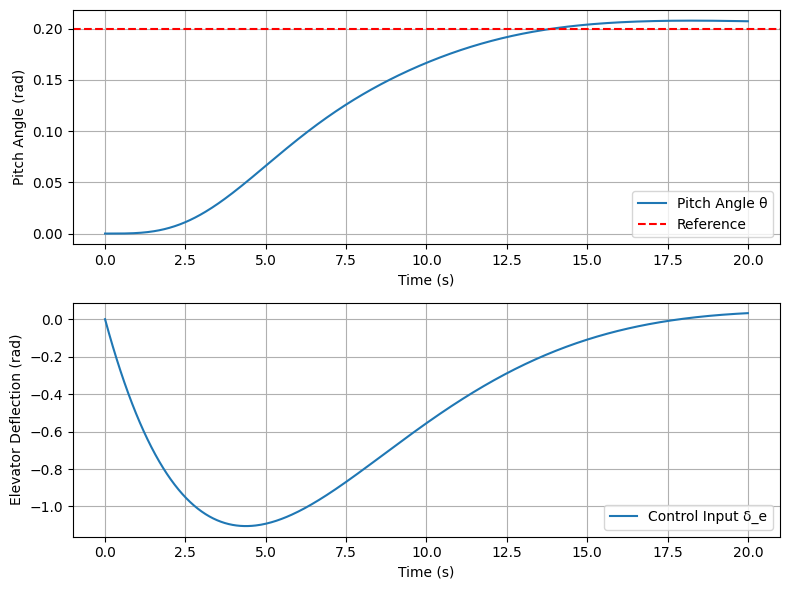

In [4]:
def closed_loop_dynamics(xi, t, r):
    x = xi[:n]
    e_i = xi[n]
    u = -K_x @ x - K_i * e_i
    dx = A @ x + B @ u
    de_i = r - C @ x
    return np.hstack((dx.flatten(), de_i.flatten()))

# Initial condition
xi0 = np.zeros(n + 1)

# Time span
t = np.linspace(0, 20, 500)

# Reference pitch
r = 0.2  # rad

# Integrate
xi = odeint(closed_loop_dynamics, xi0, t, args=(r,))

# Extract outputs
theta = xi[:, 2]
u = [-K_x @ xi[k, :n] - K_i * xi[k, n] for k in range(len(t))]

# Plot results
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].plot(t, theta, label='Pitch Angle θ')
axs[0].axhline(r, color='r', linestyle='--', label='Reference')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Pitch Angle (rad)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, u, label='Control Input δ_e')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Elevator Deflection (rad)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Results Analysis

The simulation shows the pitch angle tracking the reference with zero steady-state error due to the integral action. The control input stabilizes after the transient. This demonstrates the optimal tracking performance achieved by solving the LQR problem for the augmented system.